# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Neural Network Model

Prompt:

```md
give me a tensorflow scaffolding that:
loads test, train, validate csvs from ./data
takes 7 features in a timeseries, with seasonality, across 12 months for 14 years
outputs a signal for an entire year
```

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

# Constants here
START_DATE = datetime(2008, 1, 1)
END_DATE = datetime(2022, 12, 31)
DATA_PATH = "./data"

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
train_df.head(5)

,Plant_Production_GWh,Population_k,tmax,GDP_bln
Date,,,,
2003-01-01,182.08,398.580000,15.6,4.8200
2003-02-01,187.10,398.580000,13.0,4.8275
2003-03-01,176.37,398.804167,15.7,4.8350
2003-04-01,156.53,399.028333,18.7,4.8425
2003-05-01,163.97,399.252500,24.8,4.8500


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

FEATURES = [
    "Population_k",
    "tmax",
    "GDP_bln",
]
TARGET = "Plant_Production_GWh"

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
y_test = test_df[TARGET]
X_test = test_df[FEATURES]

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=0,
)

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
model.summary()

2/2 [==============================] - 1s 9ms/step - loss: 48801.1875
Test Loss: 48801.1875
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


2/2 [==============================] - 1s 4ms/step


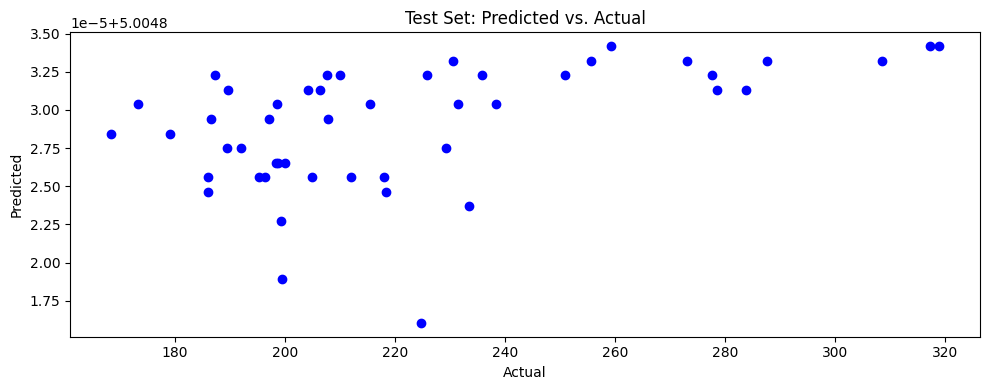

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

test_predictions = model.predict(X_test)
plt.scatter(y_test, test_predictions, color="blue")
plt.title("Test Set: Predicted vs. Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")


# absolute mess!!!! include lag, ma, and all that
plt.tight_layout()
plt.show()

Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [10]:
STEPS = 24


def encode_ts(df):
    sequences = []
    labels = []
    for i in range(len(df) - STEPS):
        sequence = df[FEATURES].iloc[i : i + STEPS].values.flatten()
        label = df[TARGET].iloc[
            i + STEPS
        ]  # Assuming 'Max_Demand_GW' is the target variable

        sequences.append(sequence)
        labels.append(label)
    X = np.array(sequences)
    y = np.array(labels)

    return X, y


X, y = encode_ts(train_df)


print(f"Shapes: {X.shape} & {y.shape}")

Shapes: (168, 72) & (168,)


In [11]:
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout, Dense

BATCH_SIZE = 32
FILTER = 8
DROPRATE = 0.01
POOL_SIZE = 3
K_SIZE = 1
NUM_OUTPUTS = 3  # Change this to the number of values you want to predict

model = Sequential(
    [
        Input(shape=(STEPS, len(FEATURES))),
        Conv1D(FILTER, kernel_size=K_SIZE, activation="relu"),
        Conv1D(FILTER, kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),
        Conv1D(FILTER, kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),
        Flatten(),
        Dropout(DROPRATE),
        Dense(
            NUM_OUTPUTS, activation="linear"
        ),  # Change activation to "linear" for regression
    ]
)

model.compile(optimizer="adam", loss="mse")
model.fit(
    X.reshape(X.shape[0], STEPS, len(FEATURES)),
    y,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=0,
)

X_test, y_test = encode_ts(test_df)
X_test_reshaped = X_test.reshape(X_test.shape[0], STEPS, len(FEATURES))
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")
model.summary()

1/1 [==============================] - 1s 576ms/step - loss: 1707.7328
Test Loss: 1707.7327880859375
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 24, 8)             32        
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 8)             72        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 8, 8)             0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 8)              72        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 8)             0         
 1D)                                                             
                   

1/1 [==============================] - 0s 228ms/step


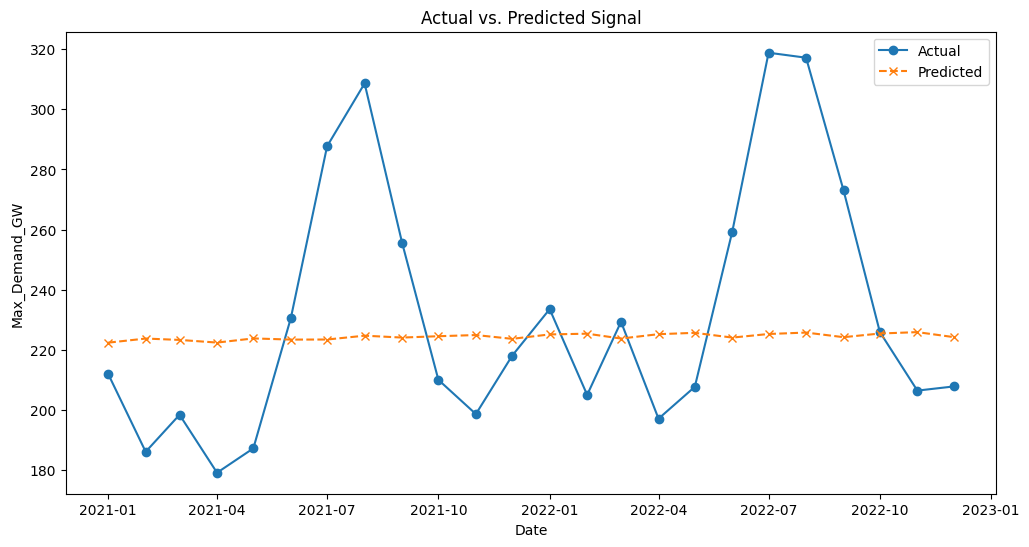

In [12]:
y_pred = model.predict(X_test_reshaped)

plt.figure(figsize=(12, 6))
index_dates = test_df.index[-len(y_test) :]
plt.plot(index_dates, y_test.flatten(), label="Actual", linestyle="-", marker="o")
plt.plot(
    index_dates,
    y_pred.flatten()[: len(y_test)],
    label="Predicted",
    linestyle="--",
    marker="x",
)

plt.title("Actual vs. Predicted Signal")
plt.xlabel("Date")
plt.ylabel("Max_Demand_GW")
plt.legend()
plt.show()